In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import string
import time
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import glob

In [2]:
imgres = 128
BATCH_SIZE = 64

def preprocess_resize(x):
    x = resize(x, (imgres, imgres), anti_aliasing=True)
    return np.array(x, dtype=np.float32)/255

datagen = ImageDataGenerator(preprocessing_function = preprocess_resize)
train_it = datagen.flow_from_directory("catdog/train",
        class_mode="binary", batch_size=64, shuffle=True,
        target_size=(imgres, imgres))
test_it = datagen.flow_from_directory("catdog/test",
        class_mode="binary", batch_size=64, shuffle=True,
        target_size=(imgres, imgres))

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [3]:
def get_simple_model():
    model = Sequential()
    model.add(layers.Conv2D(8, (5, 5), activation='relu', strides=1,
                            input_shape=(imgres, imgres, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu', strides=1))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def get_better_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imgres, imgres, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

model = get_simple_model()
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr = 0.001, momentum=0.9), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 8)       608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 16)        3216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13456)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13457     
Total params: 17,281
Trainable params: 17,281
Non-trainable params: 0
____________________________________________________

In [4]:
# Train model
tic = time.time()
history = model.fit(train_it, 
                   steps_per_epoch=len(train_it),
                   validation_data=test_it,
                   validation_steps=len(test_it),
                   epochs=40,
                   verbose=1)
toc = time.time()
print("Total Elapsed Time: ", toc-tic)

Epoch 1/40
293/293 [==============================] - 363s 1s/step - loss: 0.6789 - accuracy: 0.5640 - val_loss: 0.6605 - val_accuracy: 0.6019
Epoch 2/40
293/293 [==============================] - 357s 1s/step - loss: 0.6503 - accuracy: 0.6101 - val_loss: 0.6351 - val_accuracy: 0.6326
Epoch 3/40
293/293 [==============================] - 360s 1s/step - loss: 0.6262 - accuracy: 0.6422 - val_loss: 0.6246 - val_accuracy: 0.6461
Epoch 4/40
293/293 [==============================] - 360s 1s/step - loss: 0.6113 - accuracy: 0.6584 - val_loss: 0.6043 - val_accuracy: 0.6680
Epoch 5/40
293/293 [==============================] - 377s 1s/step - loss: 0.5930 - accuracy: 0.6850 - val_loss: 0.5877 - val_accuracy: 0.6862
Epoch 6/40
293/293 [==============================] - 275s 940ms/step - loss: 0.5790 - accuracy: 0.6975 - val_loss: 0.5821 - val_accuracy: 0.6907
Epoch 7/40
293/293 [==============================] - 353s 1s/step - loss: 0.5669 - accuracy: 0.7046 - val_loss: 0.5643 - val_accuracy: 0.7

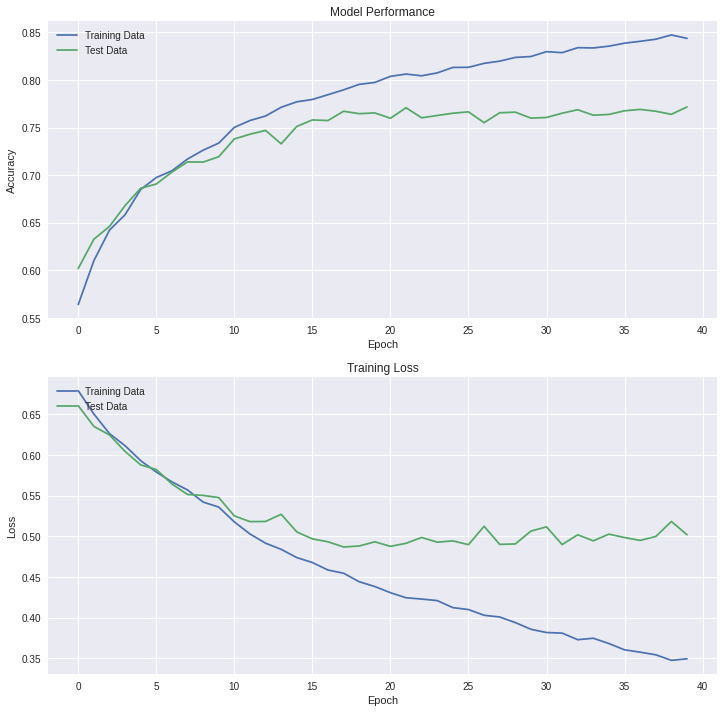

In [8]:
plt.style.use('seaborn')
plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Test Data'], loc='upper left')
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Test Data'], loc='upper left')
plt.savefig("CatDog_Simple.svg", bbox_inches='tight')

In [9]:
model.save_weights("models/catdog_simple")